In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from random import shuffle
from PIL import Image
import torchvision
import pandas as pd
import numpy as np

In [5]:
import h5py
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random

In [6]:
import matplotlib.pyplot as plt

In [7]:
import torch.nn.functional as F

In [8]:
from torch.utils.data import random_split, DataLoader

Use the following code if using colab, change to local path if using local data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install unrar
!unrar x /content/drive/MyDrive/Deep_learning_Data/ACDC_preprocessed.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Deep_learning_Data/ACDC_preprocessed.rar

Creating    ACDC_preprocessed                                         OK
Creating    ACDC_preprocessed/ACDC_testing_volumes                    OK
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient101_frame01.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient101_frame14.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient102_frame01.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient102_frame13.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient103_frame01.h5       0%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient103_frame11.h5       1%  OK 
Extracting  ACDC_preprocessed/ACDC_testing_volumes/patient104_frame01.h5       1%  OK 
Extracting  ACDC_preproce

Setting a random seed for reproducibility

In [9]:
# ensure the experiment produces same result on each run
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

In [13]:
train_folder_path = "/content/ACDC_preprocessed/ACDC_training_volumes"
test_folder_path = "/content/ACDC_preprocessed/ACDC_testing_volumes"
batch_size = 4

# Dataset class
This class creates the datasets from the corresponding folders that will later be used to creat the dataloaders

In [74]:
class H5FolderDataset(Dataset):
    def __init__(self, folder_path, target_size=(256, 232), mode='train'):
        super().__init__()
        """
        Initialize the dataset with the path to the folder containing H5 files.
        Args:
            folder_path (str): Path to the folder containing H5 files.
            target_size (tuple): Desired size (height, width) for all images and masks.
        """
        self.folder_path = folder_path
        self.target_size = target_size
        self.mode = mode

        # Collect all .h5 file paths in the folder
        self.h5_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.h5')]
        if not self.h5_files:
            raise ValueError(f"No .h5 files found in folder: {folder_path}")

        # Create a list of (file_path, index) pairs for each sample
        self.samples = []
        for h5_file in self.h5_files:
            with h5py.File(h5_file, 'r') as h5:
                num_samples = len(h5['image'])  # Assuming all H5 files have 'image' dataset
                self.samples.extend([(h5_file, idx) for idx in range(num_samples)])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Fetch the image and mask pair for a given global index.
        Args:
            idx (int): Global index of the data point.
        Returns:
            image (torch.Tensor): The image tensor.
            mask (torch.Tensor): The mask tensor.
        """
        file_path, local_idx = self.samples[idx]

        # Open the specific H5 file and read the data
        with h5py.File(file_path, 'r') as h5:
            image = h5['image'][local_idx]
            mask = h5['label'][local_idx]

        # Resize image and mask
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # Add channel dimension

        # Resize to target size
        image = torch.nn.functional.interpolate(image.unsqueeze(0), size=self.target_size, mode='bilinear').squeeze(0)
        mask = torch.nn.functional.interpolate(mask.unsqueeze(0).float(), size=self.target_size, mode='nearest').squeeze(0).long()

        return image, mask


## Create Train and Val dataloaders

In [14]:
# Create the full dataset
full_train_dataset = H5FolderDataset(folder_path=train_folder_path, mode='train')

# Define the sizes for train and validation splits
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Visualizing MRI images and corresponding masks from the train data loader

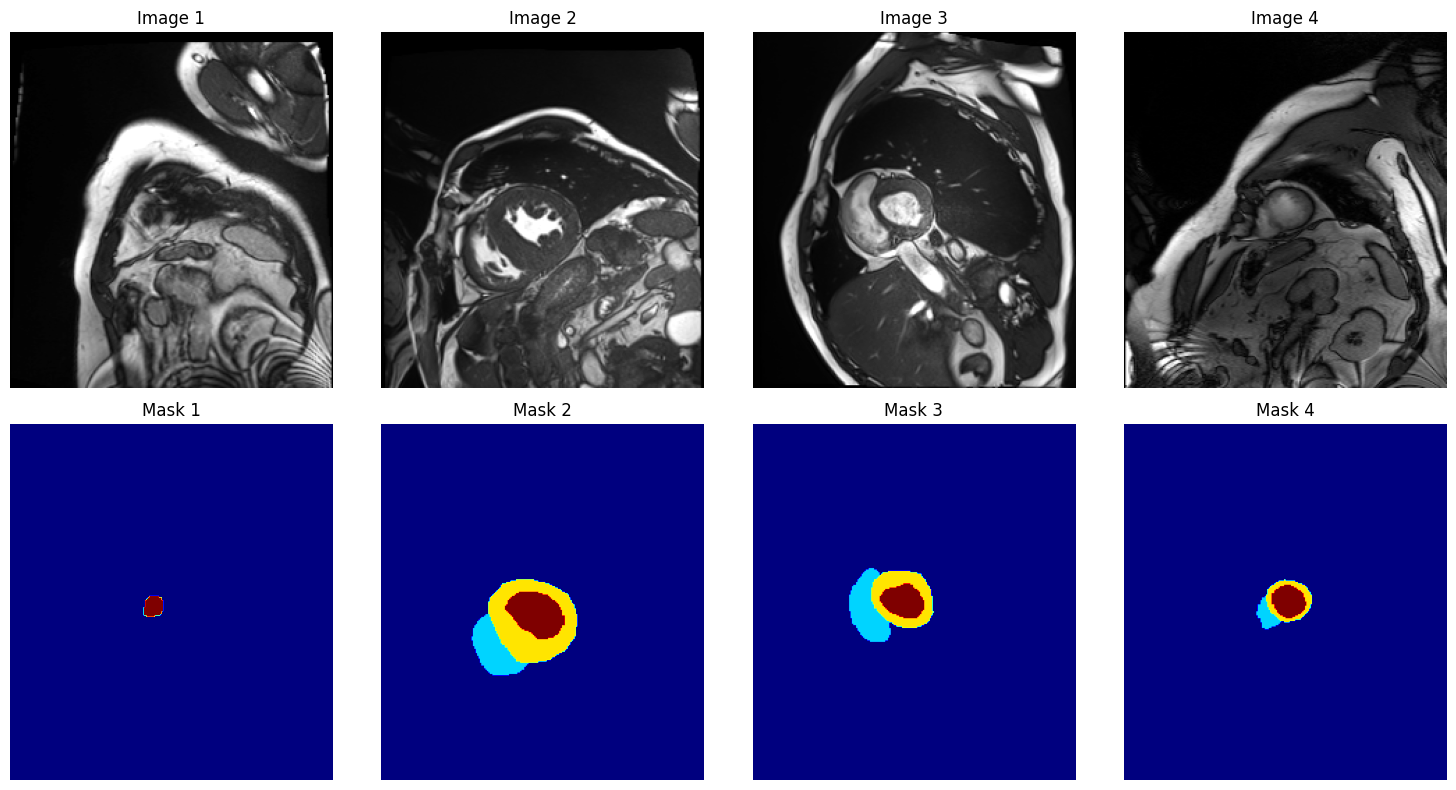

In [16]:
# Load a batch from your data loader
images, masks = next(iter(train_data_loader))  # Assuming 'images' is of shape [batch_size, C, H, W] and 'masks' is [batch_size, H, W]

# Create subplots to visualize the images and corresponding masks
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i in range(4):
    # Show the image
    # Squeeze to remove any extra dimensions, e.g., channel dimension if it's a grayscale image (C=1)
    axes[0, i].imshow(images[i].squeeze().numpy(), cmap='gray')  # Assuming grayscale images
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Image {i + 1}")

    # Show the mask (ground truth)
    axes[1, i].imshow(masks[i].squeeze().numpy(), cmap='jet')  # Assuming mask is a 2D array (H, W)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()

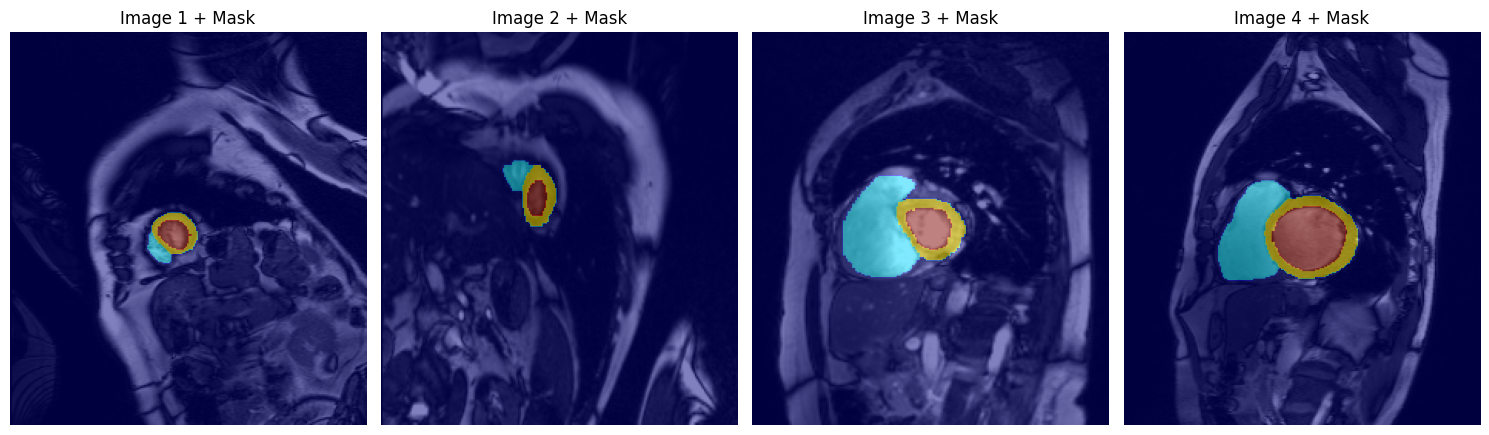

In [17]:
# Load a batch from your data loader
images, masks = next(iter(train_data_loader))  # Assuming 'images' is of shape [batch_size, C, H, W] and 'masks' is [batch_size, H, W]

# Create subplots to visualize the images and corresponding masks
fig, axes = plt.subplots(1, 4, figsize=(15, 8))

for i in range(4):
    # Show the image
    ax = axes[i]  # Select the axis for the current image

    # Display the image in grayscale
    ax.imshow(images[i].squeeze().numpy(), cmap='gray')

    # Overlay the mask on top of the image with transparency (alpha=0.5)
    ax.imshow(masks[i].squeeze().numpy(), cmap='jet', alpha=0.5)  # Adjust alpha for transparency

    # Hide axis labels
    ax.axis('off')

    # Set the title for the image and mask
    ax.set_title(f"Image {i + 1} + Mask")

plt.tight_layout()
plt.show()

# Model defining
U-Net model is used

This function is to edit output and input of decoding and encoding layers to be compatible

In [18]:
def crop_and_concat(enc_features, dec_features):
    _, _, h, w = dec_features.size()
    enc_h, enc_w = enc_features.size(2), enc_features.size(3)
    crop_h = (enc_h - h) // 2
    crop_w = (enc_w - w) // 2
    enc_features_cropped = enc_features[:, :, crop_h:crop_h + h, crop_w:crop_w + w]
    return torch.cat((enc_features_cropped, dec_features), dim=1)

In [19]:
# define loss for two-class problem
criterion = torch.nn.CrossEntropyLoss()

In [75]:
class U_Net(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):

        super(U_Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.up5 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True)
        )

        self.up_conv5 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
        )

        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )

        self.up_conv4 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
        )

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )

        self.up_conv3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )

        self.up_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
        )

        self.final = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(64, out_channels, 1)
        )

    def forward(self, x):

        # encoding path
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        # Decoding + Concat path
        d5 = self.up5(x5)
        d5 = crop_and_concat(x4, d5)
        d5 = self.up_conv5(d5)

        d4 = self.up4(d5)
        d4 = crop_and_concat(x3, d4)
        d4 = self.up_conv4(d4)

        d3 = self.up3(d4)
        d3 = crop_and_concat(x2, d3)
        d3 = self.up_conv3(d3)

        d2 = self.up2(d3)
        d2 = crop_and_concat(x1, d2)
        d2 = self.up_conv2(d2)

        d1 = self.final(d2)
        return d1

Visualize the network

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = U_Net()
model.to(device)

U_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )

Adam Optimizer is used

In [22]:
# optimizer to be used
optimizer = torch.optim.Adam(model.parameters(), 0.001, [0.5, 0.999])

In [23]:
torch.cuda.empty_cache()

In [24]:
C_CONF='expandable_segments:True'

Define checkpoint path to save best model

In [25]:
save_path = "checkpoint.pth"

In [31]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

# Training loop
for epoch in range(0, 10):
    # train
    print("epoch: ",epoch+1)
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    correct = 0
    total = 0
    for step, (images, labels) in enumerate(train_data_loader):

        # Move images and labels to device
        #batch_size = images.size(0)
        images = images.to(device)
        labels = labels.to(device)

        # Remove extra dimension from labels (if necessary)
        labels = labels.squeeze(1)  # Convert shape from (batch_size, 1, height, width) to (batch_size, height, width)

        # Forward pass (no softmax here)
        optimizer.zero_grad()
        outputs = model(images)  # Raw logits

        # Resize the output to match the target dimensions (labels)
        outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

        # Compute loss (no softmax on outputs)
        loss = criterion(outputs_resized, labels)  # Directly use raw logits
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Accuracy calculation (pixel-wise)
        for j in range(outputs_resized.shape[0]):
            output = outputs_resized[j]  # Resized predicted output for a single image
            gt = labels[j]  # Ground truth for the same image

            output = torch.argmax(output, dim=0)  # Predicted class for each pixel
            gt = gt.squeeze(0)  # Ensure ground truth is 2D

            # Exclude background (class 0) from accuracy calculation
            mask = gt != 0

            correct += float(torch.sum((output == gt) & mask))  # Correct predictions where gt != 0
            total += float(mask.sum()) # Total number of pixels in the image

    # Update training loss and accuracy
    train_loss = train_loss / len(train_data_loader)
    train_accuracy = correct / total
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    print(f"Epoch {epoch+1}/{10}")
    print(f"Training Loss: {train_loss:.4f} ")
    print(f"Training Accuracy: {train_accuracy:.4f}")

    # Save model checkpoint at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, save_path)

    # Validation loop (same as training loop but with no gradient updates)
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    correct = 0
    total = 0
    for step, (images, labels) in enumerate(val_data_loader):  # Change to validation data loader
        with torch.no_grad():
            batch_size = images.size(0)
            images = images.to(device)
            labels = labels.to(device)

            # Remove extra dimension from labels (if necessary)
            labels = labels.squeeze(1)  # Convert shape from (batch_size, 1, height, width) to (batch_size, height, width)

            # Forward pass
            outputs = model(images)  # Raw logits

            # Resize the output to match the target dimensions (labels)
            outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

            # Compute loss
            loss = criterion(outputs_resized, labels)
            val_loss += loss.item()

            # Accuracy calculation (pixel-wise)
            for j in range(outputs_resized.shape[0]):
              output = outputs_resized[j]  # Resized predicted output for a single image
              gt = labels[j]  # Ground truth for the same image
              output = torch.argmax(output, dim=0)  # Predicted class for each pixel
              gt = gt.squeeze(0)  # Ensure ground truth is 2D

              # Exclude background (class 0) from accuracy calculation
              mask = gt != 0

              correct += float(torch.sum((output == gt) & mask))  # Correct predictions where gt != 0
              total += float(mask.sum()) # Total number of pixels in the image

    # Update validation loss and accuracy
    val_loss = val_loss / len(val_data_loader)
    val_accuracy = correct / total
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{250}")
    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f} | Validation Accuracy: {val_accuracy:.4f}")

epoch:  1
Epoch 1/10
Training Loss: 0.0227 
Training Accuracy: 0.8603
Epoch 1/250
Training Loss: 0.0227 | Validation Loss: 0.0213
Training Accuracy: 0.8603 | Validation Accuracy: 0.8461
epoch:  2
Epoch 2/10
Training Loss: 0.0198 
Training Accuracy: 0.8747
Epoch 2/250
Training Loss: 0.0198 | Validation Loss: 0.0230
Training Accuracy: 0.8747 | Validation Accuracy: 0.8474
epoch:  3
Epoch 3/10
Training Loss: 0.0200 
Training Accuracy: 0.8733
Epoch 3/250
Training Loss: 0.0200 | Validation Loss: 0.0227
Training Accuracy: 0.8733 | Validation Accuracy: 0.8764
epoch:  4
Epoch 4/10
Training Loss: 0.0162 
Training Accuracy: 0.8940
Epoch 4/250
Training Loss: 0.0162 | Validation Loss: 0.0163
Training Accuracy: 0.8940 | Validation Accuracy: 0.8852
epoch:  5
Epoch 5/10
Training Loss: 0.0165 
Training Accuracy: 0.8924
Epoch 5/250
Training Loss: 0.0165 | Validation Loss: 0.0203
Training Accuracy: 0.8924 | Validation Accuracy: 0.8284
epoch:  6
Epoch 6/10
Training Loss: 0.0155 
Training Accuracy: 0.8968


In [32]:
#Create test dataloader
test_dataset = H5FolderDataset(folder_path=test_folder_path, mode='train')
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

Run saved model on the test dataloader

In [33]:
import torch
import torch.nn.functional as F
import os

# Define the save path for the checkpoint
save_path = "checkpoint.pth"

# Step 1: Load the saved model checkpoint
if os.path.exists(save_path):
    checkpoint = torch.load(save_path)

    # Initialize the model (use the same architecture as during training)
    model = model  # Make sure this matches the model used during training

    # Load the model state_dict
    model.load_state_dict(checkpoint['model_state_dict'])

    # Step 2: Switch the model to evaluation mode
    model.eval()  # This is important for inference

    # Optionally, load the optimizer state if you need to continue training
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

else:
    print("Checkpoint not found. Please train the model first.")
    exit()

# Step 3: Test the model on the test dataset
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():  # No need to compute gradients during testing
    for step, (images, labels) in enumerate(test_data_loader):
        images, labels = images.to(device), labels.to(device).squeeze(1)

        # Forward pass
        outputs = model(images)
        outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

        # Compute loss
        loss = criterion(outputs_resized, labels)
        test_loss += loss.item()

        # Pixel-wise accuracy
        preds = torch.argmax(outputs_resized, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.numel()

test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


<ipython-input-33-5ddb7d9ea21f>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_path)


Test Loss: 14.0828, Test Accuracy: 0.9461


## Visualizing model mask predicitons against actual masks

In [49]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Assuming you have a test dataloader (`test_data_loader`), criterion, and device (CPU/GPU)
# and the model is already loaded and in evaluation mode.

def visualize_result(model, test_data_loader, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No gradients needed during inference
        for step, (images, labels) in enumerate(test_data_loader):
            images, labels = images.to(device), labels.to(device).squeeze(1)

            # Forward pass
            outputs = model(images)
            outputs_resized = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=True)

            # Get the predicted mask (argmax to get the class with highest probability)
            preds = torch.argmax(outputs_resized, dim=1)

            # Convert tensors to numpy arrays for plotting (assuming batch size of 1 for simplicity)
            image = images[0].cpu().numpy()  # MRI image (typically 2D or 3D)
            actual_mask = labels[0].cpu().numpy()  # Actual ground truth mask
            predicted_mask = preds[0].cpu().numpy()  # Predicted mask

            # Plotting the results
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            # Plot the original MRI image
            axs[0].imshow(image[0], cmap='gray')  # Assuming a single channel MRI image
            axs[0].set_title("MRI Image")
            axs[0].axis('off')  # Hide axes

            # Plot the actual mask
            axs[1].imshow(actual_mask, cmap='jet')
            axs[1].set_title("Actual Mask")
            axs[1].axis('off')

            # Plot the predicted mask
            axs[2].imshow(predicted_mask, cmap='jet')
            axs[2].set_title("Predicted Mask")
            axs[2].axis('off')

            plt.show()
            break  # Show just one example for simplicity, remove if you want to visualize more

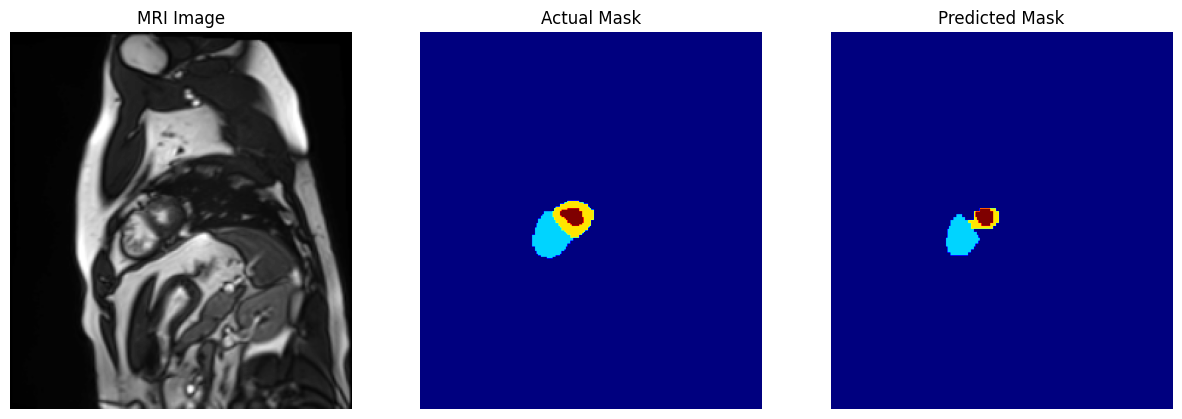

In [48]:
visualize_result(model, test_data_loader, device)

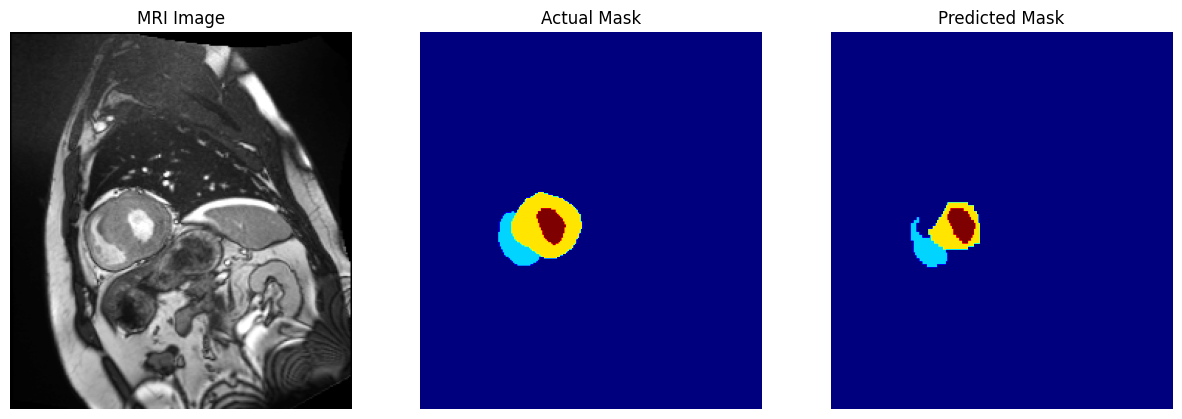

In [57]:
visualize_result(model, test_data_loader, device)

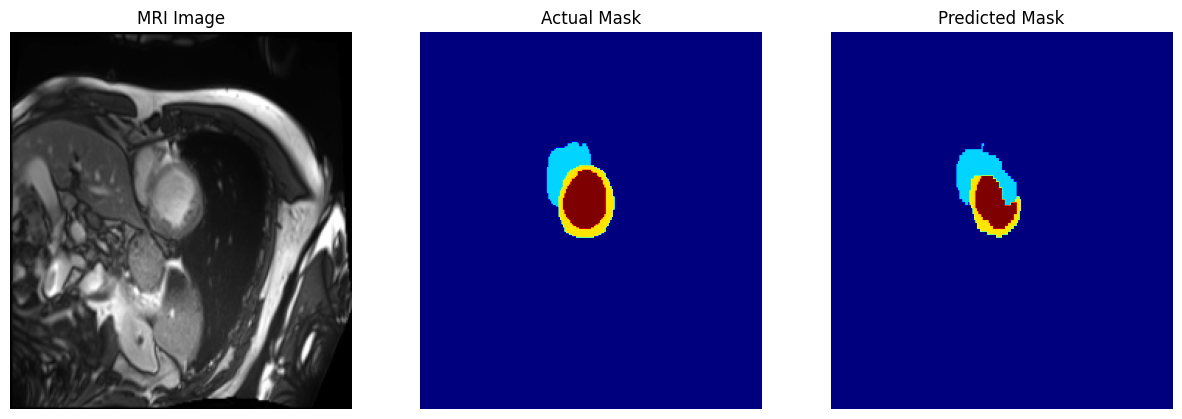

In [61]:
visualize_result(model, test_data_loader, device)